In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

import shutil

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

from google.colab import drive
drive.mount('/content/drive')
from drive.MyDrive.common.Common import NeuralNet

Mounted at /content/drive


In [2]:
device =torch.device('cuda:0')
torch.set_default_device('cuda')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving DataSolution.txt to DataSolution.txt


In [4]:
df = pd.read_csv('DataSolution.txt')
input_meas = torch.tensor(df[['t', 'x']].values, dtype=torch.float)
output_meas = torch.tensor(df[['tf']].values, dtype=torch.float)

In [5]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, constants):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Initialise constants for PDE
        self.alphf = constants[0]
        self.hf = constants[1]
        self.Th = constants[2]
        self.Tc = constants[3]
        self.T0 = constants[4]

        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE -> more weight on measurement data and bdc than pde
        self.lambda_u = 100

        # Dense NN to approximate fluid temperature
        self.approximate_f = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=8,
                                              neurons=100,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # Dense NN to approximate solid temperature
        self.approximate_s = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=8,
                                              neurons=100,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        tens =tens.to(device)
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition T_f(x,t=0)=T_0
    def initial_condition(self):
        return self.T0*torch.ones((self.n_tb,1))

    def boundary_cond_0(self, t):
        bdc = t.detach().clone()
        bdc = bdc%4     # 2 cycles with each 4 phases -> reduce to 1 cycle
        bdc = bdc<1     # only non gradient bdc for charging phase
        return bdc.reshape(-1,1)

    def boundary_cond_1(self, t):
        bdc = t.detach().clone()
        bdc = bdc%4     # 2 cycles with each 4 phases -> reduce to 1 cycle
        bdc = (bdc<3) & (bdc>=2)  # only non gradient bdc for discharging phase
        return bdc.reshape(-1,1)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition().reshape(-1, 1)
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb)).to(device)

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = self.Th*self.boundary_cond_0(input_sb[:,0]).detach()
        output_sb_L = self.T0*self.boundary_cond_1(input_sb[:,0]).detach()

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int)).to(device)
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

   ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        T_pred_tb = self.approximate_f(input_tb)  # only have initial cond. for Tf
        return T_pred_tb


    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True

        Tf = self.approximate_f(input_int)
        Ts = self.approximate_s(input_int)

        # compute gradients required
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1].to(device)

        # coefficient U in pde depends on phase -> boolean tensor depending on phase
        U = input_int[:,0].detach().clone()
        U = U%4
        U = (U<1).to(torch.float) - ((U>=2) & (U<3)).to(torch.float)
        U = U.reshape(-1,1)

        residual = grad_Tf_t + U*grad_Tf_x - self.alphf*grad_Tf_xx + self.hf*(Tf - Ts)

        return residual


    def apply_bdc(self, input_sb):

        input_sb.requires_grad = True
        Tf_sb = self.approximate_f(input_sb)
        grad_Tf_sb_x = torch.autograd.grad(Tf_sb.sum(), input_sb, create_graph=True)[0][:, 1].to(device)

        boolmap_charging_0 = self.boundary_cond_0(input_sb[:self.n_sb,0]).detach() # boolean tensor for boundary x=0 and charging phase
        boolmap_discharging_0 = self.boundary_cond_1(input_sb[:self.n_sb,0]).detach() # boolean tensor for boundary x=0 and discharging phase
        boolmap_idle_0 = 1 - boolmap_charging_0.to(torch.float) - boolmap_discharging_0.to(torch.float) # boolean tensor for boundary x=0 and idle phase

        boolmap_charging_1 = self.boundary_cond_0(input_sb[self.n_sb:,0]).detach()  # same as above just for x=1 boundary
        boolmap_discharging_1 = self.boundary_cond_1(input_sb[self.n_sb:,0]).detach()
        boolmap_idle_1 = 1 - boolmap_charging_1.to(torch.float) - boolmap_discharging_1.to(torch.float)

        # combine boolean tensors and tempertaure values to get corresponding bdc for each sample point
        boundary_vals_0 = boolmap_charging_0.squeeze()*Tf_sb[:self.n_sb].squeeze() + boolmap_discharging_0.squeeze()*grad_Tf_sb_x[:self.n_sb].squeeze() + boolmap_idle_0.squeeze()*grad_Tf_sb_x[:self.n_sb].squeeze()
        boundary_vals_1 = boolmap_charging_1.squeeze()*grad_Tf_sb_x[self.n_sb:].squeeze() + boolmap_discharging_1.squeeze()*Tf_sb[self.n_sb:].squeeze() + boolmap_idle_1.squeeze()*grad_Tf_sb_x[self.n_sb:].squeeze()

        return torch.cat([boundary_vals_0.reshape(-1,1), boundary_vals_1.reshape(-1,1)], 0)

    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):

        Tf_pred_tb = self.apply_initial_condition(inp_train_tb)
        Tf_pred_sb = self.apply_bdc(inp_train_sb)

        Tf_pred_meas = self.approximate_f(input_meas)

        res_int = self.compute_pde_residual(inp_train_int)
        res_tb = u_train_tb - Tf_pred_tb
        res_meas = output_meas - Tf_pred_meas
        res_sb = u_train_sb - Tf_pred_sb

        loss_tb = torch.mean(res_tb**2)
        loss_sb = torch.mean(res_sb**2)
        loss_meas = torch.mean(res_meas**2)
        loss_int = torch.mean(res_int**2)

        fct_loss = loss_tb + loss_meas + loss_sb

        loss = torch.log10(self.lambda_u*fct_loss + loss_int)

        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(fct_loss).item(), 4), "| Meas Loss: ", round(torch.log10(loss_meas).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True, verbose_red=False):
        history = list()

        # verbose_red is for reduced printing every 100 epochs
        # Loop over epochs
        for epoch in range(num_epochs):

            if epoch%100==0:
                if verbose_red: print("################################ ", epoch, " ################################")

            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output_f = self.approximate_f(inputs)
        output_s = self.approximate_s(inputs)

        output_f = output_f.to("cpu")
        output_s = output_s.to("cpu")
        inputs = inputs.to("cpu")

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_f.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_s.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("F")
        axs[1].set_title("S")

        plt.show()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Total loss:  -0.8497 | PDE Loss:  -1.1939 | Function Loss:  -3.1115 | Meas Loss:  -3.1177
Total loss:  -0.8497 | PDE Loss:  -1.1939 | Function Loss:  -3.1116 | Meas Loss:  -3.1177
Total loss:  -0.8497 | PDE Loss:  -1.1939 | Function Loss:  -3.1116 | Meas Loss:  -3.1177
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1116 | Meas Loss:  -3.1177
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1116 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1116 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1117 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1117 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1117 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss:  -1.1939 | Function Loss:  -3.1117 | Meas Loss:  -3.1178
Total loss:  -0.8498 | PDE Loss: 

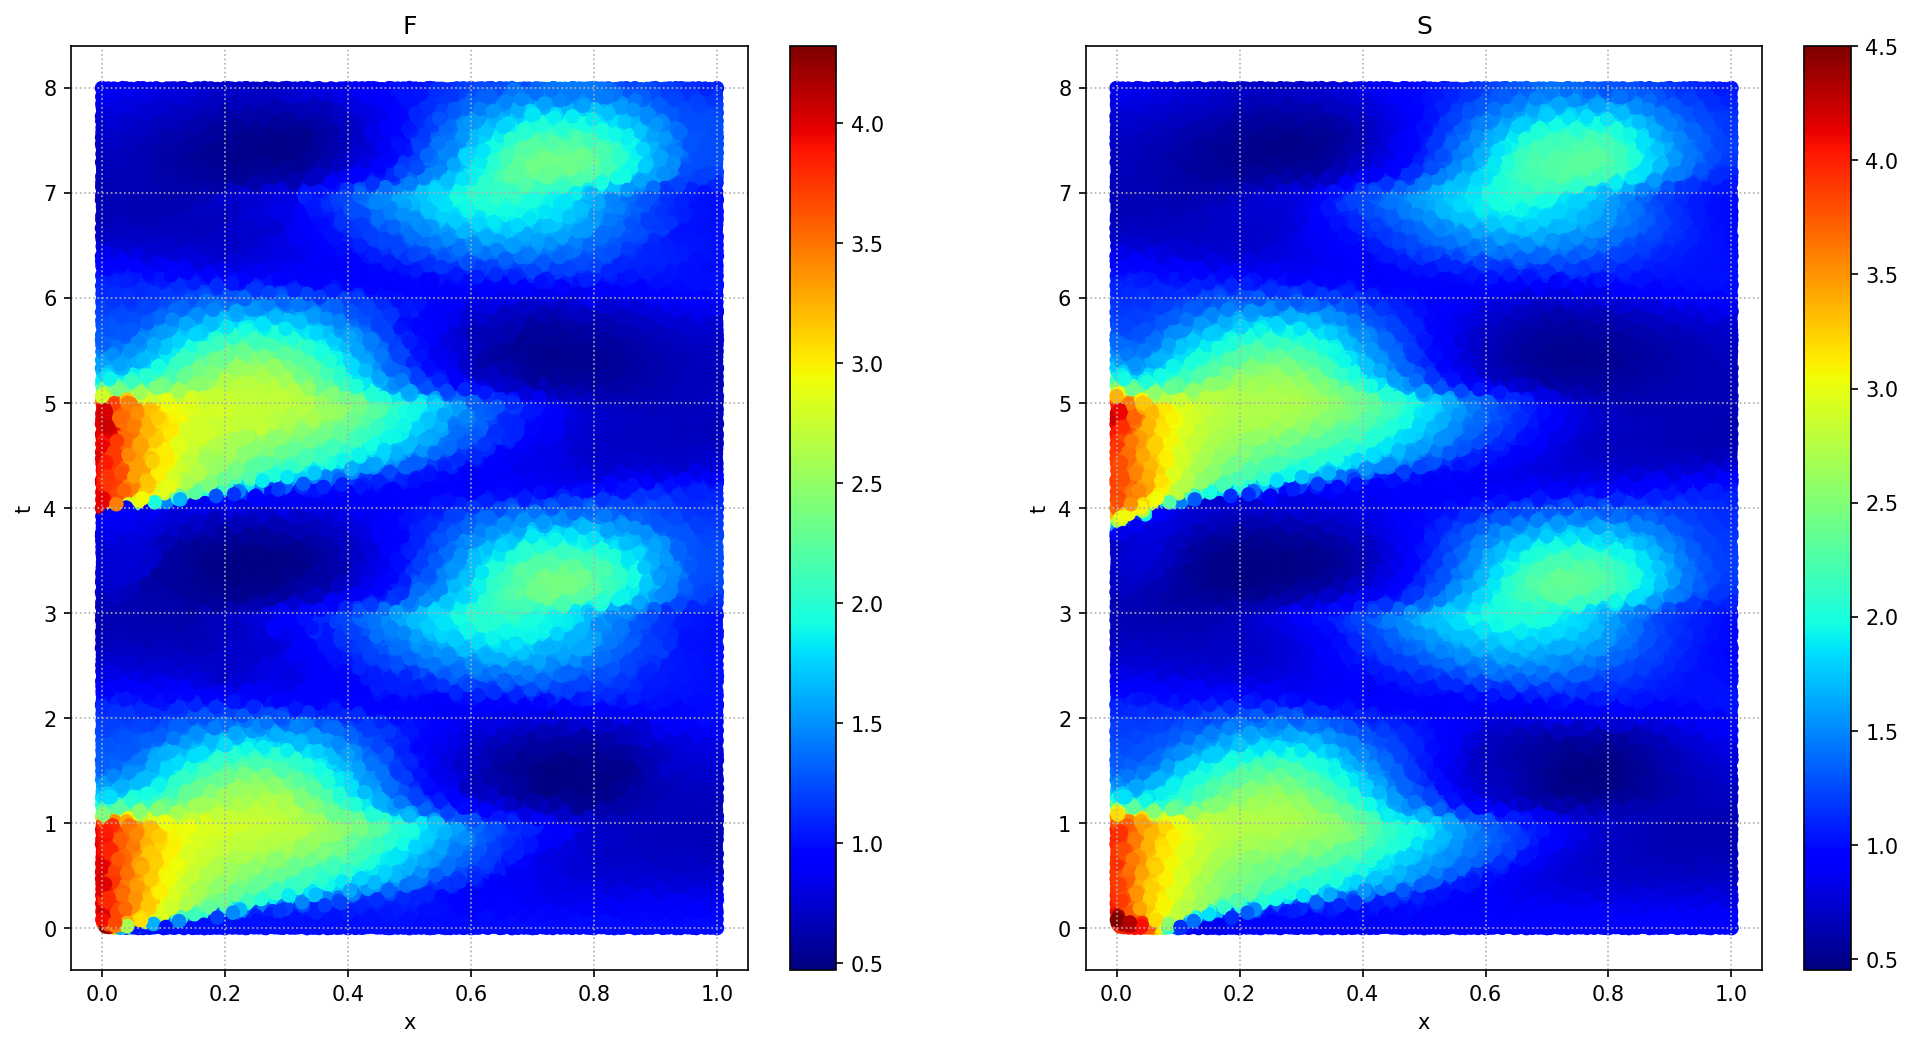

tensor(-2.2759, device='cuda:0', grad_fn=<Log10Backward0>)


'plt.figure(dpi=150)\nplt.grid(True, which="both", ls=":")\nplt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")\nplt.xscale("log")\nplt.legend()\nplt.show()'

In [ ]:
n_int = 256*4
n_sb = 64*4
n_tb = 64*2
constants = np.array([0.005, 5., 4., 1., 1.])

pinn = Pinns(n_int, n_sb, n_tb, constants)

optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_f.parameters()) + list(pinn.approximate_s.parameters()),
                            lr=float(0.5),
                            max_iter=50000,
                            max_eval=50000,
                            history_size=150,
                            line_search_fn="strong_wolfe",
                            tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(list(pinn.approximate_f.parameters()) + list(pinn.approximate_s.parameters()),
                        lr=float(0.001))

n_epochs = 5000

n_epochs_lbfgs = 1

hist = pinn.fit(num_epochs=n_epochs,
            optimizer=optimizer_ADAM,
            verbose=False, verbose_red=True)

hist = pinn.fit(num_epochs=n_epochs_lbfgs,
            optimizer=optimizer_LBFGS,
            verbose=True, verbose_red=False)

pinn.plotting()

output_s_pred = pinn.approximate_s(input_meas)

test_df = pd.DataFrame({'t': input_meas[:,0].detach().cpu().numpy() , 'x': input_meas[:,1].detach().cpu().numpy(), 'ts': output_s_pred.squeeze().detach().cpu().numpy()})
test_df.to_csv('test_output_task2_lam100.txt', index=False)

destination_folder = '/content/drive/My Drive/Colab Notebooks/'
shutil.move('test_output_task2_lam100.txt', destination_folder + 'test_output_task2_lam100.txt')